In [20]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import imodelsx.process_results
import pickle as pkl
import viz
import sys
import notebook_helper
from matplotlib.backends.backend_pdf import PdfPages
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/tree-prompt/feb25'
results_dir = '/home/chansingh/mntv1/tree-prompt/mar17'

r = imodelsx.process_results.get_results_df(results_dir)

# fill missing args with default values from argparse
experiment_filename = '../experiments/01_fit.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['mean_llm_calls'] = notebook_helper.add_mean_llm_calls(r)


# filter
# r[r['verbalizer_num'] == 0]

# group using these experiment hyperparams when averaging over random seeds
group_keys = [
    k for k in imodelsx.process_results.get_main_args_list(experiment_filename)
    if not k == 'seed'
]
ravg = (
    r
    .groupby(by=group_keys)
    .mean(numeric_only=True)
    .reset_index()
)

# display all rows
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(
#         ravg
#         .sort_values(by=['dataset_name', 'model_name', 'num_prompts'], ascending=True)
#         .reset_index()
#         [['dataset_name', 'model_name', 'num_prompts', 'prompt_source', 'verbalizer_num', 'roc_auc_test']]
#         .round(3)
#     )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 104/104 [00:07<00:00, 14.39it/s]


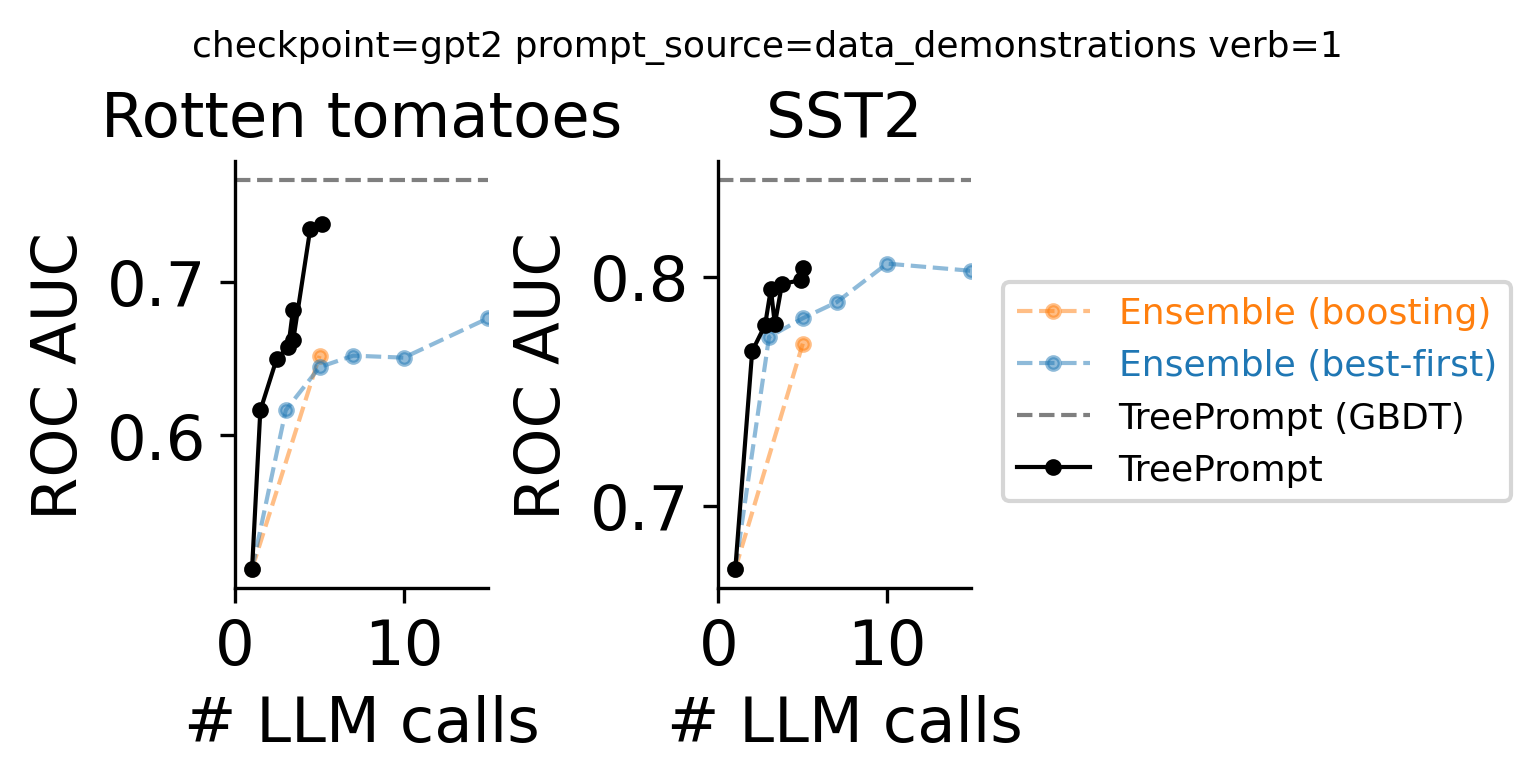

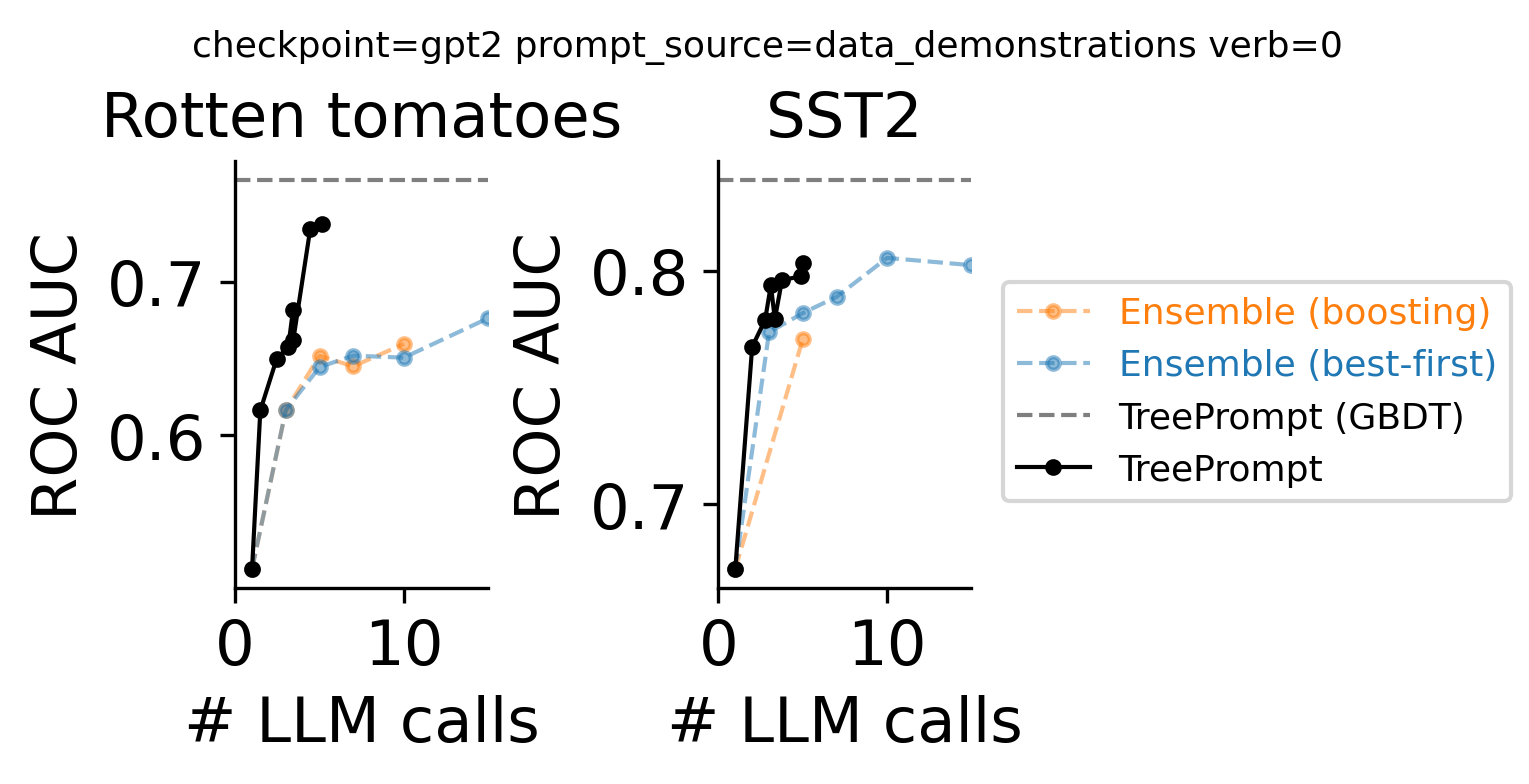

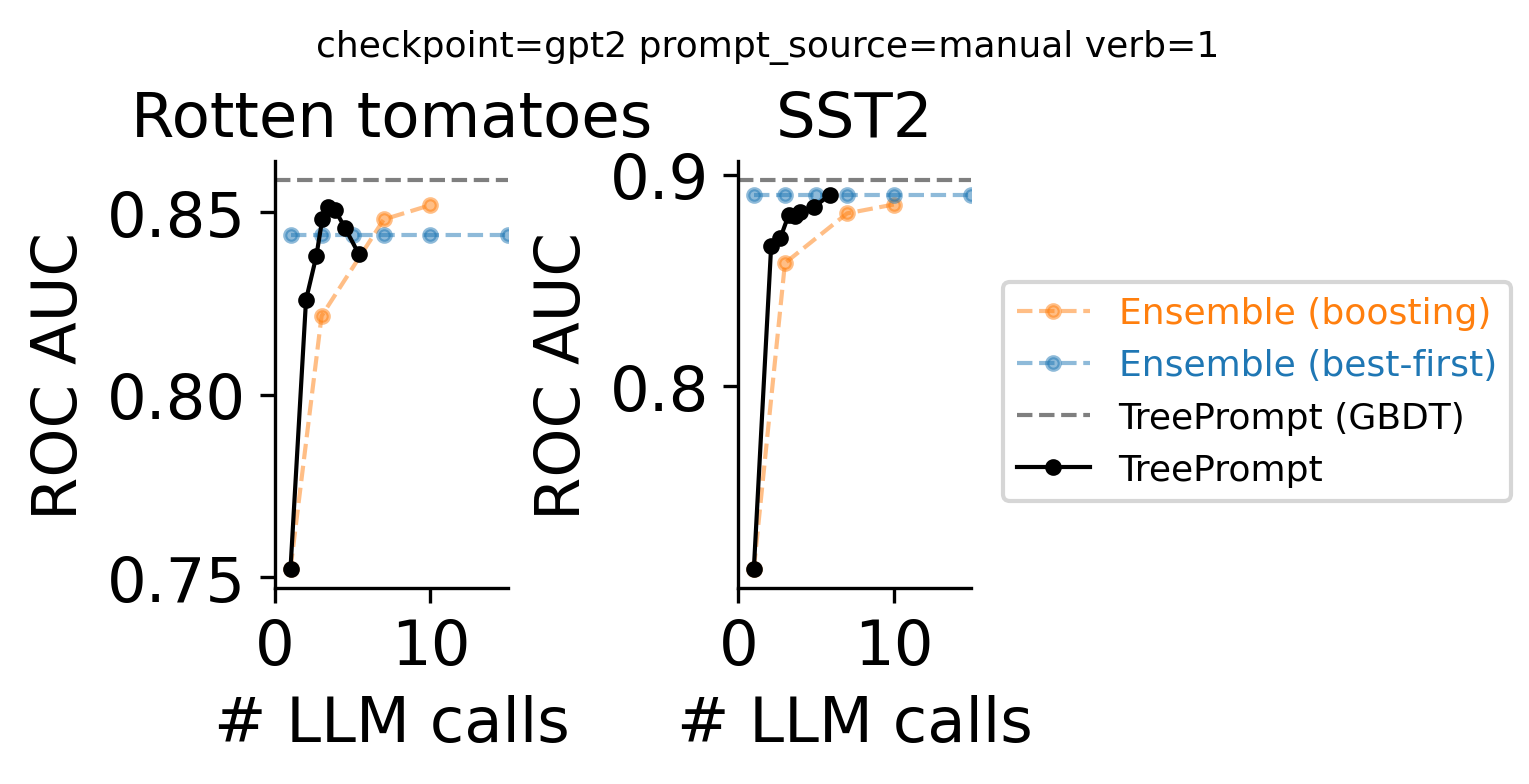

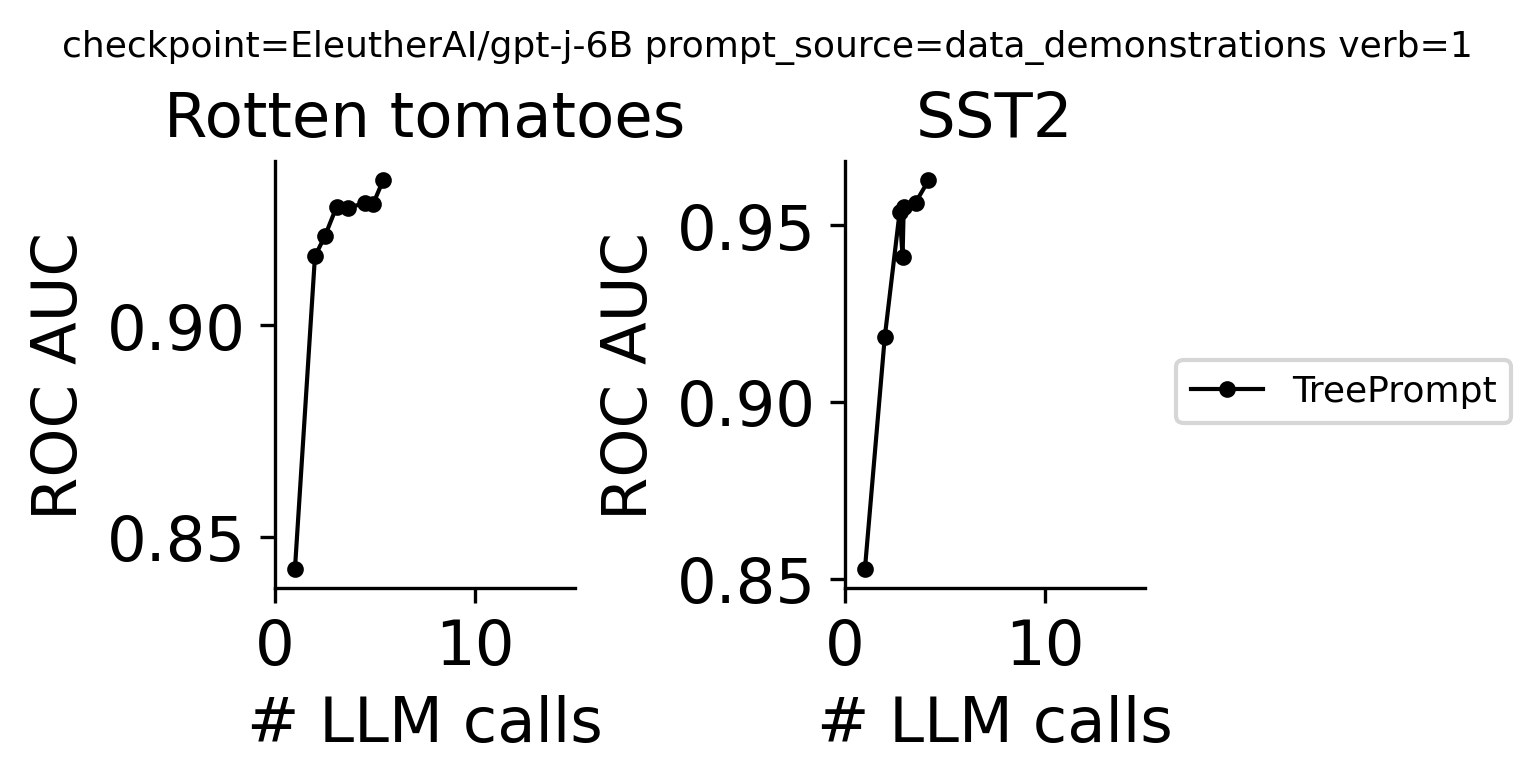

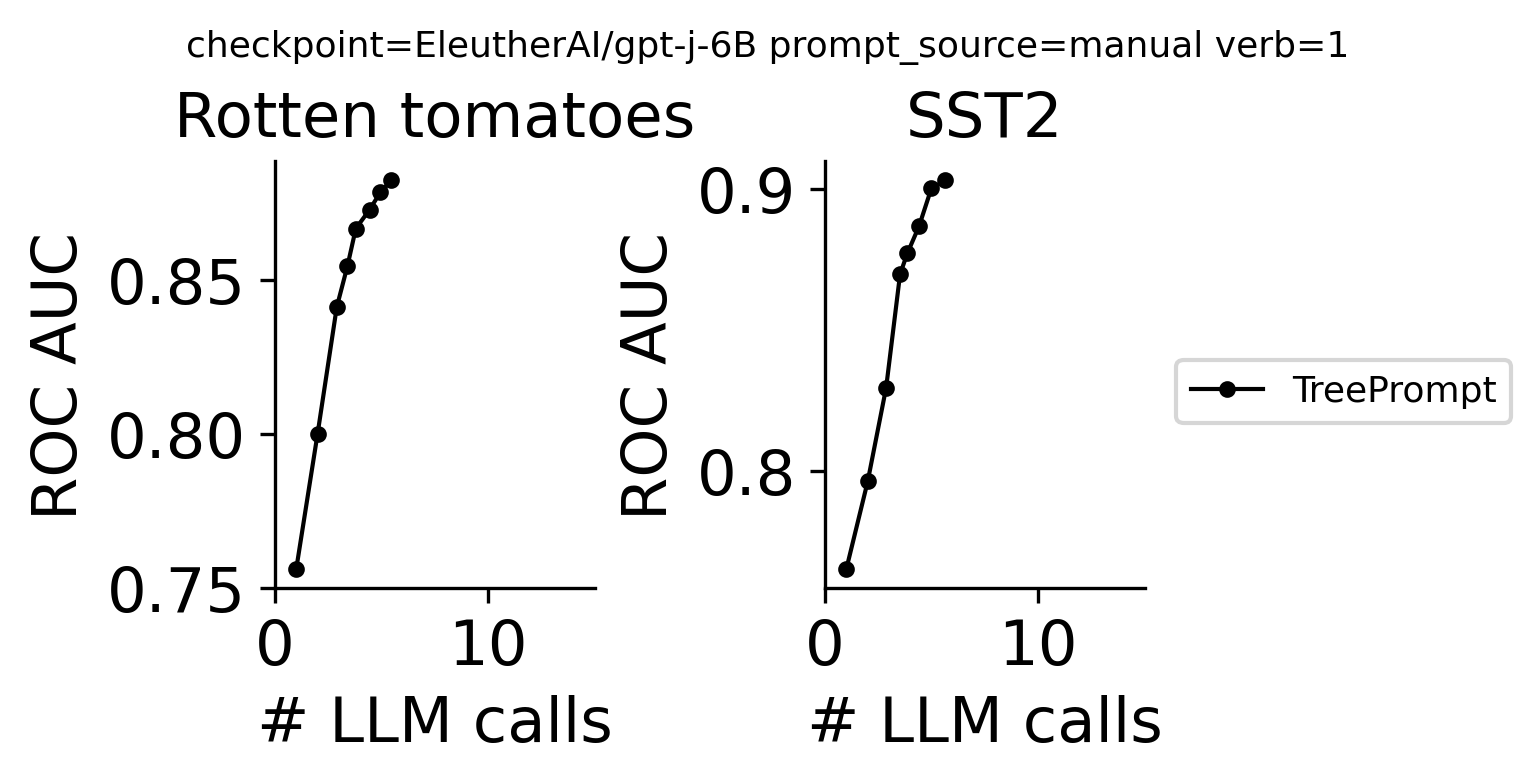

In [17]:
for checkpoint in r['checkpoint'].unique():
    for prompt_source in r['prompt_source'].unique():
        for verbalizer_num in r['verbalizer_num'].unique():

            rcurve = ravg[ravg.checkpoint == checkpoint]
            rcurve = rcurve[rcurve.prompt_source == prompt_source]
            rcurve = rcurve[rcurve.verbalizer_num == verbalizer_num]
            if len(rcurve) > 0:
                rcurve = rcurve.sort_values(by=['dataset_name', 'model_name', 'mean_llm_calls'])

                groupings = ['model_name', 'max_features', 'ngrams',
                            'refinement_strategy', 'use_llm_prompt_context', 'use_stemming']
                metric = 'roc_auc'
                # metric = 'accuracy'
                x = 'mean_llm_calls'                # x = 'num_prompts'

                viz.plot_perf_curves_individual(rcurve, x=x, xlim=15)
                plt.suptitle(f'checkpoint={checkpoint} prompt_source={prompt_source} verb={verbalizer_num}', fontsize='xx-small')
                # plt.suptitle(f'{prompt_source} prompts', fontsize='x-small')
                # plt.show()
                # plt.tight_layout()
                # plt.show()

# viz.save_figs_to_single_pdf("all_results.pdf")

### Apply cross-validation

In [ ]:
# apply cross validation
ravg_cv = (
    ravg
    .sort_values(by='accuracy_cv', ascending=False)
    .groupby(by=['split_strategy', 'dataset_name'])
    .first()
    .reset_index()
)
ravg_cv

In [ ]:
sns.barplot(data=ravg_cv, x='model_name', y='accuracy_test') #, hue='dataset_name')
plt.show()

Load an individual model

In [ ]:
run_args = r[r.model_name == 'manual_tree'].iloc[0]
model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))
model